In [1]:
from binpack.models import Result
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.stats import descriptivestats

In [2]:
results = Result.objects.filter(n_tiles=20, improved_sel=True)

In [3]:
results.values('score')

<QuerySet [{'score': 4.0}, {'score': 2.0}, {'score': 6.0}, {'score': 2.0}, {'score': 3.0}, {'score': 3.0}, {'score': 5.0}, {'score': 5.0}, {'score': 5.0}, {'score': 3.0}, {'score': 3.0}, {'score': 3.0}, {'score': 3.0}, {'score': 2.0}, {'score': 4.0}, {'score': 3.0}, {'score': 3.0}, {'score': 4.0}, {'score': 4.0}, {'score': 4.0}, '...(remaining elements truncated)...']>

In [4]:
def calc_p_value(results, max_depth_instances, avg_depth_instances, is_guillotine=True): 
    max_depth_wins = 0
    avg_depth_wins = 0
    draws = 0
    values = []
    for max_depth_res in max_depth_instances:
        if is_guillotine:
            kwargs = {'problem_id': max_depth_res.problem_id}
        else:
            kwargs = {'their_id': max_depth_res.their_id}
        kwargs['score__isnull'] =  False
        avg_depth_res = results.filter(
            strategy='avg_depth',
            **kwargs,
            )
        if avg_depth_res.count() == 1:
            avg_depth_score = avg_depth_res.first().score
            max_depth_score = max_depth_res.score
            if avg_depth_score > max_depth_score: # lower is better
                max_depth_wins +=1 
                values.append(1)
            elif avg_depth_score < max_depth_score:
                avg_depth_wins += 1
                values.append(-1)
            else:
                draws += 1
                
    print(f'In total max_depth_wins: {max_depth_wins}, avg_depth_wins: {avg_depth_wins}, and {draws} ties.')
    
    m = descriptivestats.sign_test(values)
    print(f'p value: {m[1]}')

In [5]:
'''
gets problem_id's of problems which were solved by all variations
'''
def get_best_problem_ids(N=1000, guillotine=True):
    ret = []
    common_args = {'improved_sel': True, 'score__isnull': False}
    problem_ids = set()
    for r in Result.objects.filter(n_simulations=5000, **common_args):
        if guillotine:
            common_args['problem_generator'] = 'guillotine'
            count = len(set(Result.objects.filter(problem_id=r.problem_id, **common_args).values_list('strategy', 'n_simulations')))
            problem_ids.add((r.problem_id, count))
        else:
            common_args['problem_generator'] = 'florian'
            count = len(set(Result.objects.filter(their_id=r.their_id, **common_args).values_list('strategy', 'n_simulations')))
            problem_ids.add((r.their_id, count))
            
    problem_ids = sorted(problem_ids, key=lambda x: x[1])
    N_COMBINATIONS = 12 # 100, 200, 500, 1k, 2k, 5k for avg and max depth
    ret =  [x[0] for x in problem_ids if x[1] == N_COMBINATIONS]
    return ret[:1000]

In [6]:
best_problem_ids = get_best_problem_ids()
best_their_ids = get_best_problem_ids(guillotine=False)

In [26]:
def eliminate_duplicate_tiles(tiles):
    i = 0
    new_tiles = []
    while i < len(tiles):
        tile = tiles[i]
        tiles_without_current_tile = tiles[i + 1:]
        tile_pair_index = tiles_without_current_tile.index([tile[1], tile[0]]) + i + 1
        tiles = tiles[0: tile_pair_index] + tiles[tile_pair_index + 1:]
        i += 1 
    return tiles

b_problems = Result.objects.filter(their_id__in=best_their_ids, n_simulations=5000, 
                                 improved_sel=True, strategy='max_depth', score__isnull=False
                                 ).values('rows', 'cols', 'tiles', 'n_tiles', 'their_id')
all_lists = list(b_problems.values_list('tiles', flat=True))
_all_list_strs = []
for l in all_lists:
    _all_list_strs.append(str(sorted(l)))
print(len(set(_all_list_strs)))
# print(_all_list_strs)

# check if any list contains duplicates inside
for l in all_lists:
    # print(l)
    #l = eliminate_duplicate_tiles(l)
    _l = [tuple(x) for x in l]
    # print(_l)
    new_set = set()
    for el in _l:
        new_set.add(el)
    if len(new_set) != 40:
        print('duplicate found')
        

1000


In [37]:
'''
Output just problems to csvs
'''
g_problems = Result.objects.filter(problem_id__in=best_problem_ids, n_simulations=5000, 
                                 improved_sel=True, strategy='max_depth', score__isnull=False
                                 ).values('rows', 'cols', 'tiles', 'n_tiles')

b_problems = Result.objects.filter(their_id__in=best_their_ids, n_simulations=5000, 
                                 improved_sel=True, strategy='max_depth', score__isnull=False
                                 ).values('rows', 'cols', 'tiles', 'n_tiles', 'their_id')

       
import csv, os
for file_name, problems in [('problems_g.csv', g_problems), ('problems_b.csv', b_problems)]:
    with open(os.path.join('problems/', file_name), 'w') as csv_file:
        fieldnames = ['rows', 'cols', 'tiles', 'n_tiles']
        if file_name == 'problems_b.csv':
            fieldnames.append('external_id')
        csv_writer = csv.writer(csv_file, delimiter=';')
        csv_writer.writerow(fieldnames)
        for problem in problems:
            row = [problem['rows'], problem['cols'],
                   str(eliminate_duplicate_tiles(problem['tiles'])), problem['n_tiles']]
            if file_name == 'problems_b.csv':
                row.append(problem['their_id'])
            csv_writer.writerow(row)


In [45]:
'''
Output problems with results to csv
'''

N_SIM = [100, 200, 500, 1000, 2000, 5000]

import csv, os
for file_name in ['results_g.csv', 'results_b.csv']:
    # find same problem instances
    with open(os.path.join('csv_results/', file_name), 'w') as csv_file:
        print('*' * 50)
        fieldnames = ['rows', 'cols', 'tiles', 'n_tiles',
                      'strategy', 'n_simulations', 'score',
                      'solution_found',  'n_tiles_placed', 'created_on']
        if file_name == 'results_b.csv':
            fieldnames.append('external_id')
        csv_writer = csv.writer(csv_file, delimiter=';')
        csv_writer.writerow(fieldnames)
        for n_sim in N_SIM:
            if file_name == 'results_g.csv':
                problems = Result.objects.filter(
                    problem_id__in=best_problem_ids, n_simulations=n_sim, 
                    improved_sel=True, score__isnull=False
                ).values()
            else:
                problems = Result.objects.filter(
                    their_id__in=best_their_ids, n_simulations=n_sim, 
                    improved_sel=True, score__isnull=False
                ).values()

            for problem in problems:
                row = [problem['rows'], problem['cols'],
                       str(eliminate_duplicate_tiles(problem['tiles'])), problem['n_tiles']]
                for fieldname in fieldnames[4:-1]:
                    row.append(problem[fieldname])
                if file_name == 'results_b.csv':
                    row.append(problem['their_id'])
                csv_writer.writerow(row)


**************************************************
**************************************************


1000
1000
<class 'django.db.models.query.QuerySet'>


Text(0.5, 51.0, 'columns')

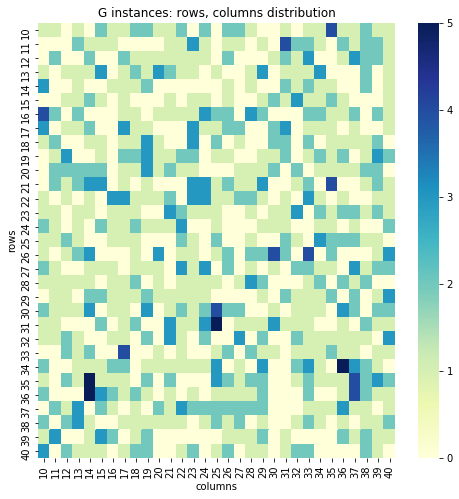

In [65]:
import pandas as pd
print(len(best_problem_ids))
rows_cols = Result.objects.filter(problem_id__in=best_problem_ids, n_simulations=5000, 
                                 improved_sel=True, strategy='max_depth', score__isnull=False
                                 ).values('rows', 'cols')
print(len(rows_cols))
print(type(rows_cols))
rows_cols = [{'rows': x['rows'], 'cols': x['cols']} for x in rows_cols]
df = pd.DataFrame(rows_cols)
matrix = np.zeros((41, 41))
for v in rows_cols:
    matrix[v['rows'], v['cols']] += 1
matrix = matrix[10:, 10:]
plt.figure(figsize=(8,8))
plt.title('G instances: rows, columns distribution')
pd = pd.DataFrame(matrix, columns=range(10, 41), index=range(10, 41))
sns.heatmap(pd, cmap='YlGnBu')
plt.ylabel('rows')
plt.xlabel('columns')

In [76]:
tiles = Result.objects.filter(problem_id__in=best_problem_ids, n_simulations=5000, 
                                 improved_sel=True, strategy='max_depth', score__isnull=False
                                 ).values('tiles')

from collections import defaultdict
tiles_count = defaultdict(int)
for tile_dict in tiles:
    _tiles = tile_dict['tiles']
    for one_tile in _tiles:
        if one_tile[0] == one_tile[1]:
            tiles_count[(one_tile[0], one_tile[1])] += 1
            
print('Count of squares in problems:', tiles_count)

            
    
    

Count of squares in problems: defaultdict(<class 'int'>, {(1, 1): 5534, (4, 4): 242, (2, 2): 498, (8, 8): 42, (6, 6): 86, (3, 3): 132, (5, 5): 70, (7, 7): 34, (14, 14): 22, (20, 20): 2, (9, 9): 38, (10, 10): 16, (13, 13): 8, (16, 16): 16, (12, 12): 4, (24, 24): 2, (11, 11): 6, (15, 15): 8, (21, 21): 2, (22, 22): 2, (18, 18): 2, (17, 17): 2})


In [7]:
print(len(best_problem_ids))
print(len(best_their_ids))

1000
1000


In [8]:
common_args = {'problem_generator': 'florian', 'improved_sel': True}

N_SIM = [100, 200, 500, 1000, 2000, 5000]

# find same problem instances
for n_sim in N_SIM:
    print('*' * 50)
    print(f'SIMULATIONS: {n_sim}')
    print('*' * 50)
    common_args['problem_generator'] = 'guillotine'
    common_args['n_simulations'] = n_sim
    common_args['score__isnull'] = False

    g_max_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='max_depth', **common_args)
    g_avg_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='avg_depth', **common_args)

    print('Guillotine:')
    calc_p_value(Result.objects.filter(problem_id__in=best_problem_ids, **common_args), g_max_depth_instances, g_avg_depth_instances)

    common_args['problem_generator'] = 'florian'
    ng_avg_depth_instances = Result.objects.filter(strategy='avg_depth', their_id__in=best_their_ids,  **common_args)
    ng_max_depth_instances = Result.objects.filter(strategy='max_depth', their_id__in=best_their_ids, **common_args)
    ng_avg_depth_scores = ng_avg_depth_instances.values('score')
    ng_max_depth_scores = ng_max_depth_instances.values('score')

    print('Non-guillotine:')
    calc_p_value(Result.objects.filter(**common_args), ng_max_depth_instances, ng_avg_depth_instances, is_guillotine=False)

    # scores = results.values('score', 'strategy')
    # print(np.average(np.array(results.filter(score__isnull=False, strategy='avg_depth', **common_args).values_list('rows', flat=True))))
    # print(np.average(np.array(results.filter(score__isnull=False, strategy='max_depth', **common_args).values_list('rows', flat=True))))

**************************************************
SIMULATIONS: 100
**************************************************
Guillotine:
In total max_depth_wins: 146, avg_depth_wins: 246, and 608 ties.
p value: 4.998327370747247e-07
Non-guillotine:
In total max_depth_wins: 461, avg_depth_wins: 147, and 392 ties.
p value: 1.1721393347580135e-38
**************************************************
SIMULATIONS: 200
**************************************************
Guillotine:
In total max_depth_wins: 168, avg_depth_wins: 216, and 616 ties.
p value: 0.016352801511807895
Non-guillotine:
In total max_depth_wins: 519, avg_depth_wins: 127, and 354 ties.
p value: 4.058279577695039e-57
**************************************************
SIMULATIONS: 500
**************************************************
Guillotine:
In total max_depth_wins: 158, avg_depth_wins: 191, and 651 ties.
p value: 0.08658146120188336
Non-guillotine:
In total max_depth_wins: 574, avg_depth_wins: 103, and 323 ties.
p value: 3.89091

In [9]:
def score_to_int(df):
    df['score'] = df['score'].astype('int')
    return df

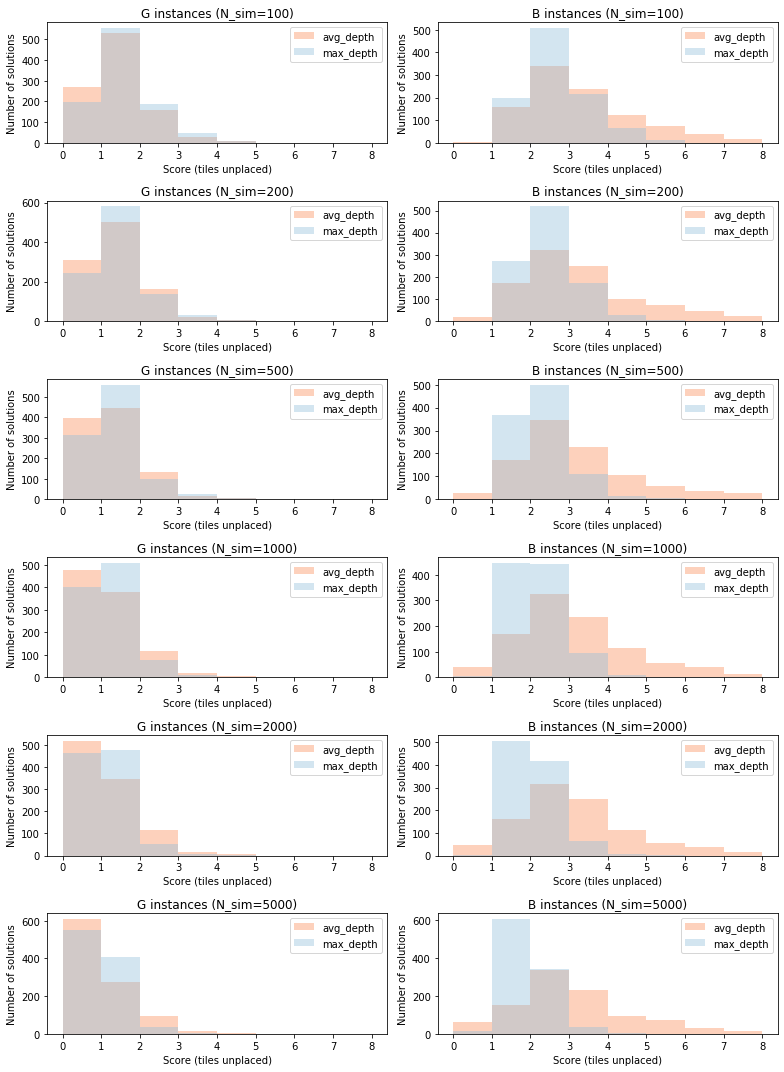

In [38]:
# scores_df
f, axes = plt.subplots(len(N_SIM), 2, figsize=(11, 15))
for j, n_sim in enumerate(N_SIM):
    common_args = {
        'score__isnull': False, 'improved_sel': True,
        'n_simulations': n_sim
    }
    bins = np.arange(0, 9)
    rows = len(N_SIM) // 2
    for i in range(2):
        if i == 0:
            common_args['problem_generator'] = 'guillotine'
            title = f'G instances (N_sim={n_sim})'
            avg_depth_scores = Result.objects.filter(problem_id__in=best_problem_ids, strategy='avg_depth', **common_args).values('score')
            max_depth_scores = Result.objects.filter(problem_id__in=best_problem_ids, strategy='max_depth', **common_args).values('score')
        else:
            title = f'B instances (N_sim={n_sim})'
            common_args['problem_generator'] = 'florian'
            avg_depth_scores = Result.objects.filter(their_id__in=best_their_ids, strategy='avg_depth', **common_args).values('score')
            max_depth_scores = Result.objects.filter(their_id__in=best_their_ids, strategy='max_depth', **common_args).values('score')

        sns.distplot(score_to_int(pd.DataFrame.from_records(avg_depth_scores)),
                     kde=False, color='#fc8d59', label='avg_depth', bins=bins, ax=axes[j][i])
        sns.distplot(score_to_int(pd.DataFrame.from_records(max_depth_scores)),
                          kde=False, color='#91bfdb', label='max_depth', bins=bins, ax=axes[j][i])
        axes[j][i].xaxis.set_major_locator(ticker.MultipleLocator(1))
        axes[j][i].xaxis.set_major_formatter(ticker.ScalarFormatter())
        # plt.xlim(left=i)
        axes[j][i].set_ylabel('Number of solutions')
        axes[j][i].set_xlabel('Score (tiles unplaced)')
        axes[j][i].set_title(title)
        axes[j][i].legend()
        
f.tight_layout()
# plt.rcParams["figure.figsize"] = (8,5)
plt.show()

### Simulation runs vs score

100 2000
200 2000
500 2000
1000 2000
2000 2000
5000 2000
[0 1 2 3 4 5]
Number of tiles non-placed in correlation with simulation runs


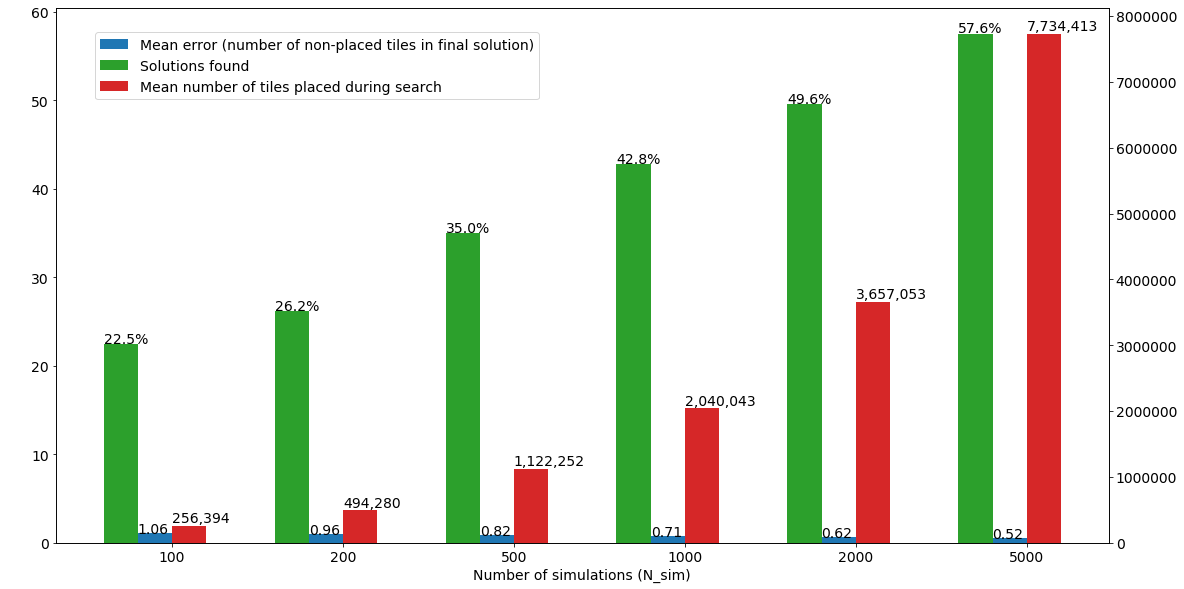

100 2000
200 2000
500 2000
1000 2000
2000 2000
5000 2000
[0 1 2 3 4 5]
Number of tiles non-placed in correlation with simulation runs


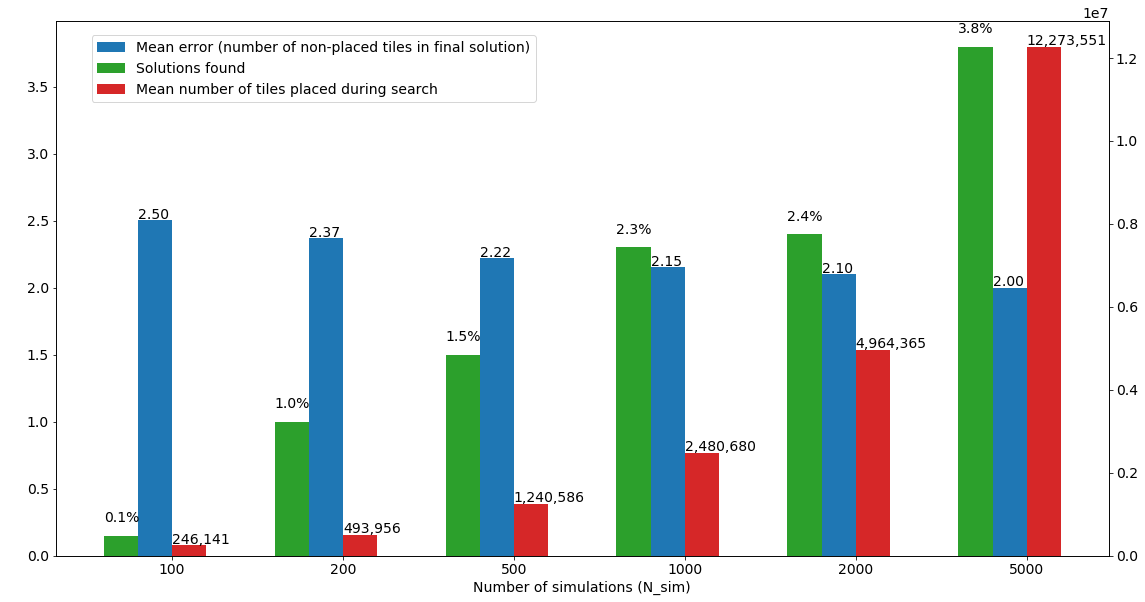

In [49]:
from collections import defaultdict, OrderedDict
from matplotlib.ticker import FuncFormatter, MaxNLocator
SIMULATION_RUNS = N_SIM
def format_fn(tick_val, tick_pos):
    if int(tick_val) in range(0, len(SIMULATION_RUNS)):
        return SIMULATION_RUNS[int(tick_val)]
    else:
        return ''
x_vals = defaultdict(list)
results = OrderedDict()

plt.rcParams["figure.figsize"] = (15,3)

for problem_type in ['g', 'b']:
    for n_simulations in SIMULATION_RUNS:
        common_args = {
            # 'problem_id__in': best_problem_ids,
            # 'strategy': 'max_depth',
            'n_simulations': n_simulations,
            'improved_sel': True, 'score__isnull': False
        }
        if problem_type == 'g':
            common_args['problem_id__in'] = best_problem_ids
        else:
            common_args['their_id__in'] = best_their_ids
        avg_score = np.average(np.array(Result.objects.filter(
            **common_args).order_by('their_id').values_list('score', flat=True)))
        results[n_simulations] = {'median score': avg_score}
        avg_tiles = np.average(np.array(Result.objects.filter(
            **common_args).order_by('their_id').values_list('n_tiles_placed', flat=True)))
        solutions_found = (Result.objects.filter(
            solution_found=True,**common_args).order_by('their_id').count() / 
            Result.objects.filter(**common_args).order_by('their_id').count() * 100)

        print(n_simulations, Result.objects.filter(**common_args).count())
        results[n_simulations]['median tiles placed'] = avg_tiles
        results[n_simulations]['solutions found'] = solutions_found

    fig,  ax1 = plt.subplots()
    x = np.arange(0, len(SIMULATION_RUNS) )
    print(x)
    y = np.arange(0,3)
    width_offset = 0.10
    width = 0.2 
    for i, score_type in enumerate(['median score', 'median tiles placed', 'solutions found']):
        # print(result)
        sc = [v[score_type] for k, v in results.items()]
        current_ax = ax1
        color = 'tab:blue'
        label = 'Mean error (number of non-placed tiles in final solution)'
        if i == 1:
            color = 'tab:red'
            ax2 = ax1.twinx()
            current_ax = ax2
            width_offset = -width_offset
            label = 'Mean number of tiles placed during search'
        if i == 2:
            color = 'tab:green'
            # ax2 = ax1.twinx()
            width_offset = -3 *  width_offset
            label = 'Solutions found'
        current_ax.bar(x - width_offset, sc, width=width, 
                label=label, color=color)
        if i != 2:
            current_ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
            current_ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        for j, v in enumerate(sc): 
            offset = width_offset 
            text = '{:.2f}'.format(v)
            _offset = 0.1
            _offset_top = 0.01
            if v >  100:
                text = '{:,.0f}'.format(v)
                _offset = 0.10
                _offset_top = 50000.35
            if i == 2:
                text = '{:.1f}%'.format(v)
                if problem_type == 'g':
                    _offset_top = 0.1
            current_ax.text(x[j] - offset - _offset, v + _offset_top, text)

    plt.rcParams["font.size"] = 14
    # plt.yticks(ticks=np.arange(0, 4))
    ax1.set_xlabel('Number of simulations (N_sim)')
    # ax1.set_ylabel('Median error (number of non-placed tiles in final solution)')
    # ax2.set_ylabel('Median number of tiles placed during search')
    fig.legend(loc=(0.08, 0.83))
    fig.subplots_adjust(top=2.6, right=1.1)
    print('Number of tiles non-placed in correlation with simulation runs')
    plt.show()

In [40]:
Result.objects.filter(n_simulations=2000).values('score', 'problem_id')


Result.objects.filter(n_simulations=1000).values('score', 'problem_id').filter(problem_id='eeca903e-157c-4f82-9c7f-ad75a41c6b1b')

<QuerySet []>

### Compare n_tiles

5 40 {'median score': 0.0}
6 40 {'median score': 0.0}
7 40 {'median score': 0.0}
8 40 {'median score': 0.0}
9 40 {'median score': 0.05}
10 40 {'median score': 0.125}
11 40 {'median score': 0.425}
12 40 {'median score': 0.45}
13 40 {'median score': 0.7}
14 40 {'median score': 0.875}
15 40 {'median score': 0.8}
16 40 {'median score': 1.675}
17 40 {'median score': 1.775}
18 40 {'median score': 1.375}
19 40 {'median score': 1.8}
20 40 {'median score': 1.05}
21 40 {'median score': 2.05}
22 40 {'median score': 1.925}
23 40 {'median score': 2.15}
24 40 {'median score': 2.15}
25 40 {'median score': 2.4}
26 40 {'median score': 3.5}
27 40 {'median score': 2.35}
28 40 {'median score': 2.475}
29 40 {'median score': 2.45}
30 40 {'median score': 2.725}
[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30]
Number of tiles non-placed in correlation with simulation runs


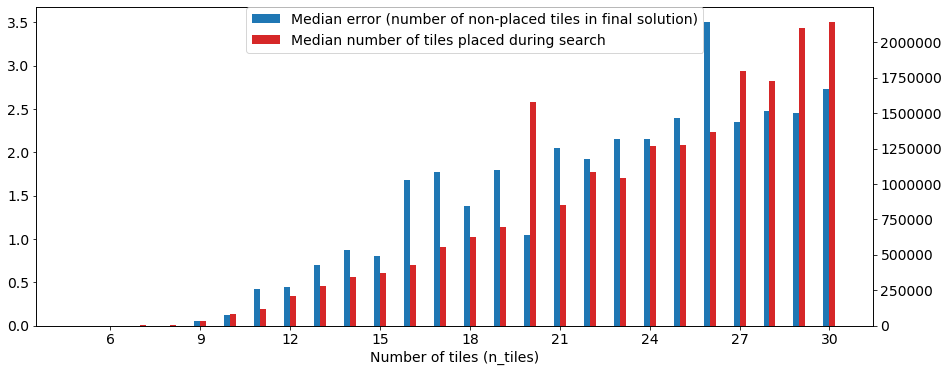

In [41]:
from collections import defaultdict, OrderedDict
from matplotlib.ticker import FuncFormatter, MaxNLocator

N_TILES = list(range(5, 31))

def format_fn(tick_val, tick_pos):
    return str(int(tick_val))
    if int(tick_val) in N_TILES:
        return N_TILES[int(tick_val)]
    else:
        return ''
    
x_vals = defaultdict(list)
results = OrderedDict()

plt.rcParams["figure.figsize"] = (15,3)

LAST_N_RECORDS = 40

for n_tiles in N_TILES:
    common_args = {
        'strategy': 'max_depth', 'n_tiles': n_tiles,
        'score__isnull': False, 'n_tiles_placed__isnull': False,
        'n_simulations': 1000, 'problem_generator': 'guillotine'
    }
    res_avg_score = Result.objects.filter(**common_args).order_by('-created_on').values_list('score', flat=True)[:LAST_N_RECORDS]
    if res_avg_score:
        avg_score = np.average(np.array(res_avg_score))
    else:
        avg_score = 0
    results[n_tiles] = {'median score': avg_score}
    
    res_tiles_placed = Result.objects.filter(**common_args).order_by('-created_on').values_list('n_tiles_placed', flat=True)[:LAST_N_RECORDS]
    if res_tiles_placed:
        avg_tiles = np.average(np.array(res_tiles_placed))
    else:
        avg_tiles = 0
    print(n_tiles, res_tiles_placed.count(), results[n_tiles])
    results[n_tiles]['median tiles placed'] = avg_tiles
    
fig,  ax1 = plt.subplots()
x = np.arange(N_TILES[0], N_TILES[-1] + 1)
print(x)
y = np.arange(0,3)
width_offset = 0.10
width = 0.2 
for i, score_type in enumerate(['median score', 'median tiles placed']):
    # print(result)
    sc = [v[score_type] for k, v in results.items()]
    current_ax = ax1
    color = 'tab:blue'
    label = 'Median error (number of non-placed tiles in final solution)'
    if i == 1:
        color = 'tab:red'
        ax2 = ax1.twinx()
        current_ax = ax2
        width_offset = -width_offset
        label = 'Median number of tiles placed during search'
    current_ax.bar(x - width_offset, sc, width=width, 
            label=label, color=color)
    current_ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    current_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # for i, v in enumerate(sc): 
    #     offset = width_offset 
    #     text = '{:.3f}'.format(v)
    #     _offset = 0.12
    #     _offset_top = 0.01
    #     if v >  10:
    #         text = '{:.0f}'.format(v)
    #         _offset = 0.10
    #         _offset_top = 50000.35
    #     current_ax.text(x[i] - offset - _offset, v + _offset_top, text)
   
plt.rcParams["font.size"] = 14
# plt.yticks(ticks=np.arange(0, 4))
ax1.set_xlabel('Number of tiles (n_tiles)')
# ax1.set_ylabel('Median error (number of non-placed tiles in final solution)')
# ax2.set_ylabel('Median number of tiles placed during search')
fig.legend(loc='upper center')
fig.subplots_adjust(top=1.6)
print('Number of tiles non-placed in correlation with simulation runs')
plt.show()

### Tiles placed (Huristic vs MCTS)

In [42]:
instances_where_solution_is_found = Result.objects.filter(solution_found=True, n_tiles=20, problem_generator='florian').values('n_tiles_placed', 'their_tiles_placed')
scores_df = pd.DataFrame.from_records(instances_where_solution_is_found)
scores_df

,n_tiles_placed,their_tiles_placed
0,1428425,6118
1,6167470,6118
2,3942386,3845
3,918972,6919
4,3191908,6919
...,...,...
234,14302436,75
235,14302436,75
236,858933,29007
237,962642,22


In [54]:
STRATEGIES = ['avg_depth', 'max_depth']
common_args = {
    'n_tiles': 20, 
    'score__isnull': False, 
    'improved_sel': True,
    'their_id__in': best_their_ids
}
N_SIM = [100, 200, 500, 1000, 2000, 5000]
for strategy in STRATEGIES:
    for n_sim in N_SIM:
        solutions_found = Result.objects.filter(
            solution_found=True, problem_generator='florian', n_simulations=n_sim, strategy=strategy, **common_args).count()
        solutions_not_found = Result.objects.filter(
             problem_generator='florian', n_simulations=n_sim, strategy=strategy, **common_args).count()
        tiles_placed = np.average(np.array(Result.objects.filter(problem_generator='florian', n_simulations=n_sim, strategy=strategy, **common_args).values_list('n_tiles_placed', flat=True)))
        error = np.average(np.array(Result.objects.filter(problem_generator='florian', n_simulations=n_sim, strategy=strategy, **common_args).values_list('score', flat=True)))
        print(f'Florian instances with {n_sim} simulations and strategy {strategy}:')
        print(f'solutions found: {solutions_found} / {solutions_not_found} = {solutions_found / solutions_not_found * 100} %')
        print(f'tiles placed: {tiles_placed}')
        print(f'{solutions_found / solutions_not_found * 100 : .1f}% \t {int(round(tiles_placed)):,} \t {error}')
        print()

Florian instances with 100 simulations and strategy avg_depth:
solutions found: 3 / 1000 = 0.3 %
tiles placed: 260901.445
 0.3% 	 260,901 	 2.817

Florian instances with 200 simulations and strategy avg_depth:
solutions found: 18 / 1000 = 1.7999999999999998 %
tiles placed: 525225.486
 1.8% 	 525,225 	 2.766

Florian instances with 500 simulations and strategy avg_depth:
solutions found: 27 / 1000 = 2.7 %
tiles placed: 1320564.747
 2.7% 	 1,320,565 	 2.676

Florian instances with 1000 simulations and strategy avg_depth:
solutions found: 42 / 1000 = 4.2 %
tiles placed: 2638213.166
 4.2% 	 2,638,213 	 2.641

Florian instances with 2000 simulations and strategy avg_depth:
solutions found: 45 / 1000 = 4.5 %
tiles placed: 5276579.745
 4.5% 	 5,276,580 	 2.634

Florian instances with 5000 simulations and strategy avg_depth:
solutions found: 63 / 1000 = 6.3 %
tiles placed: 13005273.549
 6.3% 	 13,005,274 	 2.582

Florian instances with 100 simulations and strategy max_depth:
solutions found: 0

In [53]:
common_args = {
    'n_tiles': 20, 
    'score__isnull': False, 
    'improved_sel': True,
    'problem_id__in': best_problem_ids,
}

for strategy in STRATEGIES:
    for n_sim in N_SIM:
        print(f'Guillotine instances - {n_sim} - {strategy}:')
        solutions_found = Result.objects.filter(
            solution_found=True,  problem_generator='guillotine', n_simulations=n_sim, strategy=strategy, **common_args).count()
        solutions_not_found = Result.objects.filter(
            problem_generator='guillotine', n_simulations=n_sim, strategy=strategy, **common_args).count()
        tiles_placed = np.average(np.array(Result.objects.filter( problem_generator='guillotine', n_simulations=n_sim, strategy=strategy, **common_args).values_list('n_tiles_placed', flat=True)))
        error = np.average(np.array(Result.objects.filter( problem_generator='guillotine', n_simulations=n_sim, strategy=strategy, **common_args).values_list('score', flat=True)))
        
        print(f'solutions found: {solutions_found} / {solutions_not_found} = {solutions_found / solutions_not_found * 100} %')
        print(f'tiles placed: {tiles_placed}')
        print(f'error: {error}')
        print(f'{solutions_found / solutions_not_found * 100 : .1f}% \t {int(round(tiles_placed)):,} \t {error}')
        print()

Guillotine instances - 100 - avg_depth:
solutions found: 268 / 1000 = 26.8 %
tiles placed: 250366.87
error: 0.982
 26.8% 	 250,367 	 0.982

Guillotine instances - 200 - avg_depth:
solutions found: 309 / 1000 = 30.9 %
tiles placed: 480905.482
error: 0.911
 30.9% 	 480,905 	 0.911

Guillotine instances - 500 - avg_depth:
solutions found: 395 / 1000 = 39.5 %
tiles placed: 1092081.586
error: 0.795
 39.5% 	 1,092,082 	 0.795

Guillotine instances - 1000 - avg_depth:
solutions found: 476 / 1000 = 47.599999999999994 %
tiles placed: 1950997.218
error: 0.702
 47.6% 	 1,950,997 	 0.702

Guillotine instances - 2000 - avg_depth:
solutions found: 517 / 1000 = 51.7 %
tiles placed: 3583189.366
error: 0.646
 51.7% 	 3,583,189 	 0.646

Guillotine instances - 5000 - avg_depth:
solutions found: 609 / 1000 = 60.9 %
tiles placed: 7370383.103
error: 0.532
 60.9% 	 7,370,383 	 0.532

Guillotine instances - 100 - max_depth:
solutions found: 199 / 1000 = 19.900000000000002 %
tiles placed: 258124.412
error: 1.1

In [43]:
common_args = {
    'n_tiles': 20, 
    'score__isnull': False, 
    'improved_sel': True,
    'problem_id__in': best_problem_ids,
}
for strategy in STRATEGIES:
    for n_sim in N_SIM:
        average_tiles_placed_deterministic = Result.objects.filter(
            n_tiles=20, problem_generator='florian').aggregate(Avg('their_tiles_placed'))
        print('NG instances'); print('-' * 20)

        print('Florian tiles placed:', average_tiles_placed_deterministic)
        average_tiles_placed_deterministic = Result.objects.filter(
            n_tiles=20, problem_generator='florian', n_tiles_placed__isnull=False, strategy='max_depth').aggregate(Avg('n_tiles_placed'))
        print('MCTS tiles placed:', average_tiles_placed_deterministic); print()

        print('G instances'); print('-' * 20)
        average_tiles_placed_deterministic = Result.objects.filter(
            n_tiles=20, problem_generator='guillotine', n_tiles_placed__isnull=False, strategy='max_depth').aggregate(Avg('n_tiles_placed'))
        print('MCTS tiles placed:', average_tiles_placed_deterministic)

NG instances
--------------------
Florian tiles placed: {'their_tiles_placed__avg': 254973310.72964478}
MCTS tiles placed: {'n_tiles_placed__avg': 3529233.6111227483}

G instances
--------------------
MCTS tiles placed: {'n_tiles_placed__avg': 2107076.716373618}
NG instances
--------------------
Florian tiles placed: {'their_tiles_placed__avg': 254973310.72964478}
MCTS tiles placed: {'n_tiles_placed__avg': 3529233.6111227483}

G instances
--------------------
MCTS tiles placed: {'n_tiles_placed__avg': 2107076.716373618}
NG instances
--------------------
Florian tiles placed: {'their_tiles_placed__avg': 254973310.72964478}
MCTS tiles placed: {'n_tiles_placed__avg': 3529233.6111227483}

G instances
--------------------
MCTS tiles placed: {'n_tiles_placed__avg': 2107076.716373618}
NG instances
--------------------
Florian tiles placed: {'their_tiles_placed__avg': 254973310.72964478}
MCTS tiles placed: {'n_tiles_placed__avg': 3529233.6111227483}

G instances
--------------------
MCTS tiles